# Understanding figure 1c
This is a notebook that attempts to break down figure 1c in the original article https://www.nature.com/articles/s41586-020-2907-3.

In [48]:
import pickle
import rnaseqTools
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import sparse
import warnings
import seaborn as sns

## 1. First, what was the original article by Scala et al. doing?

Note: This is a summary written by a person from outside neuroscience. Some of the contents may be wrong.

According to the article by Scala et al., there are two ways to classify neuron types: transcriptomic and  morpho-electric. The transcriptomic method uses the RNA sequence of neurons to determine their families. The morpho-electric (morphology and electrphysiology) method first observes actual neuron shapes by coloring them with a substance called byoctin. Next it runs electrical currents through the neurons and records the reactions of the neurons. Finally, it combines the neuron shapes to their reactions under electricity to classify the cells into families.

Scala's article combined both transcriptomic and  morpho-electric descriptions to mouse neurons from the primary motor cortex (MOp) to see what it could find. The experiment showed that the morpho-electric classification agreed with the transcriptomic classification for broad cell families (Pvalb, Vip, L5 ET, and other code-like names found in the article). However, morpho-electric classification did not match transcriptomic classification for smaller neuron subclasses. The article concludes that the neuron families may not be able to be finely labeled as the transcriptomic classification suggests, but can only be labeled by the broad families with slight within-group variations. 

When assigning transcriptomic cell types, Scala et al. referenced two transcriptomic cell data sets, one from Tasic et al. 2018 and one from Yao et al. 2020. Scala et al. first used Tasic et al.'s data set to assign initial categories to the cell samples they had. Then they did the final assignment with Yao et al.'s 7 datasets for RNA sequences.

### The referenced datasets

Yao et al. classify neurons in the primary motor cortex using RNA and DNA sequencing and chromatin. Scala et al. only use the 7 datasets for the RNA sequence for assigning transciptomic cell types.<br>
https://www.biorxiv.org/content/10.1101/2020.02.29.970558v2.full.pdf

Tasic et al. classified 23,822 neurons from mice by single-cell RNA sequencing. These neurons were from two areas of mouse brains: the primary visual cortex and the anterior lateral motor cortex.<br>
https://www.nature.com/articles/s41586-020-2907-3#Abs1

## 2. What does figure 1c indicate?

According to the article, 1c is: 
>t-SNE representation of CGE-derived interneurons from the single-cell 10x v2 reference data set (n = 15,511; perplexity, 30).
 
From what can be gathered, the main data is from the "single-cell 10x v2 reference data set". The dataset contained a set of interneurons that came from a place called CGE, and in the figure, the data is represented by something called a t-SNE.

To someone with no background in neuroscience, the questions are:
1. What is an interneuron?
2. Where and what is the CGE?
3. What is a t-SNE representation?
4. Is there any meaning to the dataset's name, and where did it come from?

__1. What is a interneuron?__

It is a common type of neuron that can be found in the brain and spinal cord. They pass signals through the nervous system, which allows us to sense and move.

__2. Where and what is the CGE?__

It is a tiny region of a brain section called the telencephalon, which is associated with the motor functions (movements) of the body. Along with the CGE, there are sections called the LGE and MGE which are also part of the telencephalon. CGE is the second largest source of cortical interneurons (number one source is MGE).

__3. What is a t-SNE?__

It is a non-linear dimensionality reduction technique developed in 2008 that is effective for high-dimensional data (to compare, PCA is a linear dimensionality reduction technique). It works by using a Gaussian distribution to calculate the conditional probability of one point choosing another point as a close neighbor. It does this for the original data and for a lower dimension representation, and then uses KL divergence to decide what low dimension representation best fits the original data. It has a parameter "perplexity", which controls the "how close is a close neighbor" aspect. Like PCA, you end up with a set of unidentifiable features that are complex combinations of the original. 

For details, look at the following:
- https://www.datacamp.com/community/tutorials/introduction-t-sne
- https://distill.pub/2016/misread-tsne/
- https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf

__4. Is there any meaning to the data set's name, and where did it come from?__

Single cell sequencing is the technology of identifying a DNA or RNA sequence of one cell, and 10x sequencing is an advanced method that lets you do it. This dataset in particular is from Yao et al.'s article in 2020.

## 3. So what is figure 1c?

It is a t-SNE mapping of one group of neurons, the CGE interneurons, in one of Yao at al.'s datasets that represents the results of single cell 10x v2 RNA sequencing. This dataset can be found in `10X_cells_v2_AIBS.pickle`, a pickle file you can obtain by running `allen-data-preprocess-mod.ipynb`.

In figure 1c, clusters created by the t-SNE algorithm are colored by the actual transcriptomic cell types. Broad cell families like Vip, Lamp5, and Sncg are also plotted. The remaining groups in the dataset, the MGE interneurons and excitatory cells are mapped in figure 1d and 1e as similar plots respectively. 

### The contents of 10X_cells_v2_AIBS.pickle
It is a dictionary. The first layer keys are the subgroups: CGE interneurons (viplamp), MGE interneurons (pvsst), excitatory neurons (exc), and all groups put together (neurons). The keys each have another dictionary associated with it, which has info about the subgroups:

- __counts:__ The gene count for each cell, a sparse matrix of size `number_of_cells * number_of_genes`
- __genes:__ The gene list. This only includes 1,000 most variable genes for the neuron group and 500 most variable genes for the subgroups.
- __clusters:__ The cluster assignments for each cell. The cluster types are from Yao et al.'s article and stored in a file called `cluster.annotation.csv`. 10X_cells_v2_AIBS only uses the 88 types where `class_label != "Other"`.
- __clusterColors:__ A color assigned to each cluster. Used for plotting. This one contains the same information regardless of group.
- __clusterNames:__ A name assigned  to each cluster.
- __seqDepths:__ How many genes were read per cell. Not equal to the sum of counts, perhaps because it included genes that were not in the gene list.

### The process of t-SNE
The exact method is described in the Method section in Scala et al.'s article (https://www.nature.com/articles/s41586-020-2907-3#Sec7). This section also gives a reference to another article which invented the protocol: https://www.nature.com/articles/s41467-019-13056-x.
1. Normalize the count data so that the gene counts can be compared across all cells, each with different sequence depths. The normalization method is `log2(gene_counts_of_cell / seqdepth_of_cell * median(seqdepth_of_allcells) + 1)`
2. Do PCA on the normalized counts, so that the features are reduced from `number_of_cells * number_of_genes` to `number_of_cells * 50`
3. Perform t-SNE on the feature-reduced counts using a tool from https://github.com/KlugerLab/FIt-SNE. The tool maps to 2 dimensions unless otherwise specified

## The plotting code for Figure 1c

This section describes what is going on in the code that plots Figure 1c.

```python
Z = pickle.load(open('../data/processed/rnaseq/10x-tsne-viplamp.pickle', 'rb')) # load t-SNE representations of Yao et al.'s cells
subset = np.isin(ttypes['family'], ['Lamp5', 'Vip']) # a mask that gets cells that were assigned "Lamp5" or "Vip" in Scala et al.'s samples

# assign t-SNE representations to Scala et al.'s cells using Yao et al.'s cells as reference
# returns a t-SNE representation of the same dimension as the reference
pos = rnaseqTools.map_to_tsne(m1data['viplamp']['counts'], m1data['viplamp']['genes'],
                              m1.exonCounts[subset,:], m1.genes, Z, knn=10,
                              newIntronCounts=m1.intronCounts[subset,:], 
                              newExonLengths=m1.exonLengths, newIntronLengths=m1.intronLengths,
                              normalizeNew=True, normalizeReference=False)

# create a dictionary of t-SNE representations of Scala et al.'s cells, keys are areas of brain
pos_all = {}
pos_all['viplamp'] = pos
                              
# this block plots a scatterplot of Yao et al.'s cells, in colors specified in Yao et al.'s article
# the colors can be found in 10X_cells_v2_AIBS.pickle
plt.sca(ax3)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.scatter(Z[:,0], Z[:,1], s=1, alpha=1, rasterized=True, edgecolors='none',
            c = clusterColors[m1data['viplamp']['clusters']])

# overlay Scala et al.'s 244 cells with Yao et al.'s clusters of 15,511 CGE interneurons
# the estimated location of cells were derived in rnaseqTools.map_to_tsne()
# the marker shapes and sizes represent the layers in which the cells were found
sc = []
for L in ['1', '2/3', '5', '6']:
    s = plt.scatter(pos[layers[subset]==L,0], pos[layers[subset]==L,1], 
                    s=sizes[L], c='k', zorder=2, marker=shapes[L])
    sc.append(s)
    
leg = plt.legend(sc, ['L1','L2/3','L5','L6'], fontsize=5, loc='upper right')
leg.get_frame().set_linewidth(.5)

# from here the code plots the t-type names for the clusters
# offsets: the offset [x,y] to avoid overlap with dots on the scatterplot
# angles: set angle to make tilted captions
# renames: if you  need to set a new name for the t-types, do it here

offsets = {'Lamp5 Slc35d3': [25,-20], 'Lamp5 Lhx6': [10,6], 'Lamp5 Pdlim5_2': [20,10],
           'Lamp5 Pdlim5_1': [20,5], 'Lamp5 Pax6': [10,8], 'Lamp5 Egln3_1': [20,8],
           'Lamp5 Egln3_2': [15,7], 'Lamp5 Egln3_3': [25,16], 'Vip Igfbp6_1': [15,-10],
           'Vip Igfbp6_2': [15,-5], 'Vip C1ql1': [5,-20], 'Vip Gpc3': [0,-12],
           'Vip Chat_1': [0,-17], 'Vip Mybpc1_2': [-10,15], 'Vip Mybpc1_1': [-8,5],
           'Sncg Slc17a8': [0,9], 'Sncg Calb1_1': [-8,7], 'Sncg Calb1_2': [-12,3],
           'Sncg Npy2r': [-15,0], 'Vip Sncg': [-12,5], 'Sncg Col14a1': [7,0],
           'Vip Htr1f': [15,-9], 'Vip Serpinf1_3': [2,-10], 'Vip Serpinf1_1': [-4,3],
           'Vip Mybpc1_3': [-10,0], 'Vip Serpinf1_2': [10,0], 'Vip Chat_2': [0,-10]}

angles = {'Vip Mybpc1_1': 60, 'Sncg Col14a1': -75}
renames = {'Vip Mybpc1_3': 'M3', 'Vip Serpinf1_1': 'S1', 'Vip Serpinf1_2': 'S2', 'Vip Serpinf1_3': 'S3'}

for c in np.unique(m1data['viplamp']['clusters']): # for every cluster assigned to Yao et al.'s CGE interneurons
    ind = m1data['viplamp']['clusters']==c
    col = clusterColors[c]
    x,y = np.median(Z[ind,0]), np.median(Z[ind,1]) #set the labels at the median value of the t-SNE values for that cluster
    if clusterNames[c] in offsets: # use the offset
        x += offsets[clusterNames[c]][0]
        y += offsets[clusterNames[c]][1]
    if clusterNames[c] not in renames:
        label = '\n'.join(clusterNames[c].split()[1:]) #for brevity, keep the cell family name out and replace space with newline
    else:
        label = renames[clusterNames[c]] #rename if you need to
    if clusterNames[c] not in angles:
        alpha = 0
    else:
        alpha = angles[clusterNames[c]] #set angles to cell types if specified
        
    if ~np.isnan(x):
        plt.text(x, y, label, color=col, fontsize=5, ha='center', va='center', zorder=1, rotation=alpha)

#the next 6 rows are for plotting the cell family names: Vip, Sncg, Lamp5
col = clusterColors[clusterNames=='Vip Mybpc1_3'][0]
plt.text(-65, -50, 'Vip', color='w', fontsize=6, bbox=dict(boxstyle='round', ec=col, fc=col))
col = clusterColors[clusterNames=='Sncg Calb1_2'][0]
plt.text(-65, 55, 'Sncg', color='w', fontsize=6, bbox=dict(boxstyle='round', ec=col, fc=col))
col = clusterColors[clusterNames=='Lamp5 Slc35d3'][0]
plt.text(50, -60, 'Lamp5', color='w', fontsize=6, bbox=dict(boxstyle='round', ec=col, fc=col))

#these remove ticks from the plot and erases borderline of plot
plt.xticks([])
plt.yticks([])
sns.despine(ax=ax3, left=True, bottom=True)
```

Using a common set of 490 genes.


([], <a list of 0 Text major ticklabel objects>)

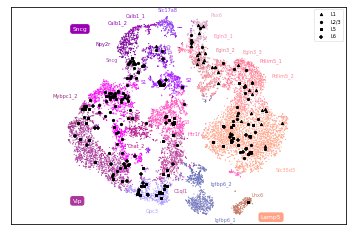

In [50]:
clusterColors = m1data['neurons']['clusterColors']
Z = pickle.load(open('../data/processed/rnaseq/10x-tsne-viplamp.pickle', 'rb')) # load t-SNE representations of Yao et al.'s cells
subset = np.isin(ttypes['family'], ['Lamp5', 'Vip']) # a mask that gets cells that were assigned "Lamp5" or "Vip" in Scala et al.'s samples

# assign t-SNE representations to Scala et al.'s cells using Yao et al.'s cells as reference
# returns a t-SNE representation of the same dimension as the reference
pos = rnaseqTools.map_to_tsne(m1data['viplamp']['counts'], m1data['viplamp']['genes'],
                              m1.exonCounts[subset,:], m1.genes, Z, knn=10,
                              newIntronCounts=m1.intronCounts[subset,:], 
                              newExonLengths=m1.exonLengths, newIntronLengths=m1.intronLengths,
                              normalizeNew=True, normalizeReference=False)

# create a dictionary of t-SNE representations of Scala et al.'s cells, keys are areas of brain
pos_all = {}
pos_all['viplamp'] = pos
                              
#plt.sca(ax3)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.scatter(Z[:,0], Z[:,1], s=1, alpha=1, rasterized=True, edgecolors='none',
            c = clusterColors[m1data['viplamp']['clusters']])



sc = []
for L in ['1', '2/3', '5', '6']:
    s = plt.scatter(pos[layers[subset]==L,0], pos[layers[subset]==L,1], 
                    s=sizes[L], c='k', zorder=2, marker=shapes[L])
    sc.append(s)
    
leg = plt.legend(sc, ['L1','L2/3','L5','L6'], fontsize=5, loc='upper right')
leg.get_frame().set_linewidth(.5)

offsets = {'Lamp5 Slc35d3': [25,-20], 'Lamp5 Lhx6': [10,6], 'Lamp5 Pdlim5_2': [20,10],
           'Lamp5 Pdlim5_1': [20,5], 'Lamp5 Pax6': [10,8], 'Lamp5 Egln3_1': [20,8],
           'Lamp5 Egln3_2': [15,7], 'Lamp5 Egln3_3': [25,16], 'Vip Igfbp6_1': [15,-10],
           'Vip Igfbp6_2': [15,-5], 'Vip C1ql1': [5,-20], 'Vip Gpc3': [0,-12],
           'Vip Chat_1': [0,-17], 'Vip Mybpc1_2': [-10,15], 'Vip Mybpc1_1': [-8,5],
           'Sncg Slc17a8': [0,9], 'Sncg Calb1_1': [-8,7], 'Sncg Calb1_2': [-12,3],
           'Sncg Npy2r': [-15,0], 'Vip Sncg': [-12,5], 'Sncg Col14a1': [7,0],
           'Vip Htr1f': [15,-9], 'Vip Serpinf1_3': [2,-10], 'Vip Serpinf1_1': [-4,3],
           'Vip Mybpc1_3': [-10,0], 'Vip Serpinf1_2': [10,0], 'Vip Chat_2': [0,-10]}

angles = {'Vip Mybpc1_1': 60, 'Sncg Col14a1': -75}
renames = {'Vip Mybpc1_3': 'M3', 'Vip Serpinf1_1': 'S1', 'Vip Serpinf1_2': 'S2', 'Vip Serpinf1_3': 'S3'}

for c in np.unique(m1data['viplamp']['clusters']): # for every cluster assigned to Yao et al.'s CGE interneurons
    ind = m1data['viplamp']['clusters']==c
    col = clusterColors[c]
    x,y = np.median(Z[ind,0]), np.median(Z[ind,1]) #set the labels at the median value of the t-SNE values for that cluster
    if clusterNames[c] in offsets: #there will definitely be overlaps with scatterplot so use the offset
        x += offsets[clusterNames[c]][0]
        y += offsets[clusterNames[c]][1]
    
    if clusterNames[c] not in renames:
        label = '\n'.join(clusterNames[c].split()[1:]) #use the cluster 
    else:
        label = renames[clusterNames[c]]
    if clusterNames[c] not in angles:
        alpha = 0
    else:
        alpha = angles[clusterNames[c]]
    
    if ~np.isnan(x):
        plt.text(x, y, label, color=col, fontsize=5, ha='center', va='center', zorder=1, rotation=alpha)
        
        
col = clusterColors[clusterNames=='Vip Mybpc1_3'][0]
plt.text(-65, -50, 'Vip', color='w', fontsize=6, bbox=dict(boxstyle='round', ec=col, fc=col))
col = clusterColors[clusterNames=='Sncg Calb1_2'][0]
plt.text(-65, 55, 'Sncg', color='w', fontsize=6, bbox=dict(boxstyle='round', ec=col, fc=col))
col = clusterColors[clusterNames=='Lamp5 Slc35d3'][0]
plt.text(50, -60, 'Lamp5', color='w', fontsize=6, bbox=dict(boxstyle='round', ec=col, fc=col))

plt.xticks([])
plt.yticks([])
#sns.despine(left=True, bottom=True)

In [36]:
clusterNames

array(['Lamp5 Pax6', 'Lamp5 Egln3_1', 'Lamp5 Egln3_2', 'Lamp5 Egln3_3',
       'Lamp5 Pdlim5_1', 'Lamp5 Pdlim5_2', 'Lamp5 Slc35d3', 'Lamp5 Lhx6',
       'Sncg Col14a1', 'Sncg Slc17a8', 'Sncg Calb1_1', 'Sncg Calb1_2',
       'Sncg Npy2r', 'Vip Sncg', 'Vip Serpinf1_1', 'Vip Serpinf1_2',
       'Vip Serpinf1_3', 'Vip Htr1f', 'Vip Gpc3', 'Vip C1ql1',
       'Vip Mybpc1_2', 'Vip Mybpc1_1', 'Vip Chat_1', 'Vip Mybpc1_3',
       'Vip Chat_2', 'Vip Igfbp6_1', 'Vip Igfbp6_2', 'Sst Chodl',
       'Sst Penk', 'Sst Myh8_1', 'Sst Myh8_2', 'Sst Myh8_3', 'Sst Htr1a',
       'Sst Etv1', 'Sst Pvalb Etv1', 'Sst Crhr2_1', 'Sst Crhr2_2',
       'Sst Hpse', 'Sst Calb2', 'Sst Pappa', 'Sst Pvalb Calb2',
       'Sst C1ql3_1', 'Sst C1ql3_2', 'Sst Tac2', 'Sst Th_1', 'Sst Th_2',
       'Sst Th_3', 'Pvalb Gabrg1', 'Pvalb Egfem1', 'Pvalb Gpr149',
       'Pvalb Kank4', 'Pvalb Calb1_1', 'Pvalb Calb1_2', 'Pvalb Reln',
       'Pvalb Il1rapl2', 'Pvalb Vipr2_1', 'Pvalb Vipr2_2', 'L2/3 IT_1',
       'L2/3 IT_2', 'L2/3 IT_

In [43]:
'\n'.join(clusterNames[c].split()[1:])

'Igfbp6_2'

In [29]:
m1data['viplamp']['clusters']

array([ 9,  8,  5, ..., 24, 19, 23])

## About ttypes.pickle

It contains information about the category assignments of 1,329 cells that were used as samples in Scala et al.'s article. Details can be found in the Methods section, under "t-Type assignment".

- __qc:__ quality control result
- __tasicCorrs:__ Pearson correlation with Tasic et al.'s cell types
- __tasic_ass:__ classification to Tasic et al.'s cell types. Basically select the one with higest correlation but cells with `qc = low quality` are assigned `nan`
- __tasic_ass_boot :__ the bootstrap result (proportion) used in assignment. The bootstrap selected 100 sets of random genes from a cell with repetition, saw what type the sets were assigned to, and selected the type with the highest proportion of assignment
- __m1ass:__ classification to Yao et al.'s cell types. Separated by the seven reference datasets
- __m1corrs:__ Pearson correlation with Yao et al.'s cell types. Separated by the seven reference datasets
- __m1boot:__ classification to Yao et al.'s cell types. Separated by the seven reference datasets
- __m1consensus_boot:__ the bootstrap result (proportion) used in the final assignment. This is a majority vote across all 7 reference datasets
- __m1consensus_ass:__ the assignment result according to the bootstrap across all datasets. In other words, `argmax(m1consensus_boot)` for every cell.
- __type:__ the names of the cell types each cell was assigned to
- __family:__ the broad cell family each cell was assigned to
- __confidence:__ the highest value in the bootstrap proportions, or in other words, the `m1consensus_boot` value corresponding to the assigned cell type

In [3]:
ttypes = pickle.load(open('../data/processed/rnaseq/ttypes.pickle', 'rb'))
subset = np.isin(ttypes['family'], ['Lamp5', 'Vip']) # a mask that can get cells that were assigned "Lamp5" or "Vip" from Scala's samples

## About m1.pickle

It contains information about the RNA sequencing Scala et al. did on their 1,329 cells. It has the full list of detected genes, so the gene number is 42,466.

- __exonCounts:__ The exon count for each cell and gene. Exons are sections of a gene. Size `number_of_cells * number_of_genes`.
- __intronCounts:__ The intron count for each cell and gene. Introns are also sections of a gene. Size`number_of_cells * number_of_genes`.
- __cells:__ Name of each cell
- __genes:__ Names of all 42,466 genes that were detected
- __layer:__ Layer of primary motor cortex in which cell was found
- __cre:__ Cre line of mouse the cell came from. Kind of like a bloodline of genetically engineered lab mice.
- __yields:__ (Probably) the concentration of RNA sampled from the cell into a fluid used for tesing
- __traced:__ Whether the cell's morphology could be recorded. 646 cells were recorded in total
- __depth:__ How deep the soma (neuron's body) could be found in the brain. Probably larger the deeper
- __thickness:__ The cortical thickness of the area corresponding to that cell. Cortical thickness is the thickness of the brain's outer layers, where the cells were sampled from.
- __ephys:__ 29 electrophysiological features for each cell. Size `number_of_cells * number_of_features`
- __ephysNames:__ The names of the 29 features
- __exclude:__ Contain reasons for exclusion for cells that were excluded for analysis. Cells that were not excluded have the value `''`
- __mice_ages:__ The ages of the 266 mice used in the experiment. In days
- __mice_cres:__ The Cre line of each mouse
- __morphometrics:__ The 61 recorded morphometric features for each cell. The features will be a list of nans for cells that couldn't be measured
- __morphometricsNames:__ Names of the 61 morphometric features
- __zProfiles:__ (Probably) a histogram with 20 bins per cell that indicates the mass of the neuron located at each depth. Size `number_of_cells * number_of_bins`
- __exonLengths:__ The length of the exon for each gene
- __intronLengths:__ The length of the intron for each gene

## What is going on in rnaseqTools.map_to_tsne?

This section is for understanding what goes on when rnaseqTools.map_to_tsne is called when plotting figure 1c. Below is a copy of the function from `rnaseqTools.py` with comments that describe what is happening in the code.

```python
def map_to_tsne(referenceCounts, referenceGenes, newCounts, newGenes, referenceAtlas, 
                bootstrap = False, knn = 10, nrep = 100, seed = None, batchsize = 1000,
				verbose = 1,
                referenceIntronCounts = None, newIntronCounts = None,
                normalizeNew = False, normalizeReference = False,
                newExonLengths = None, newIntronLengths = None):
    """
    This function assigns t-SNE representations to cells by 
    1. Calculating the normalized exonic + intronic expression levels for new cells
    2. Getting their correlations to the reference counts
    3. Assigning the median t-SNE representation of the reference cells highest correlation
    4. Bootstrapping if specified
    
    The arguments are:
    referenceCounts: The exon counts for reference cells. If the counts are not separated into exons and introns, it is used for gene counts. Figure 1c uses the gene counts for 15,511 Vip/Lamp5 cells from Yao et al.
    referenceGenes: The gene name list for reference cells
    newCounts: The exon counts for the new cells that need to be assigned t-SNE representations. If the counts are not separated into exons and introns, it is used for gene counts. Figure 1c uses the 244 Vip/Lamp5 cells from Scala et al.
    newGenes: The names of genes that were detected in the new cells
    referenceAtlas: The t-SNE mappings of the reference cells. Figure 1c uses the mapping of 15,511 Yao's Vip/Lamp5 cells
    bootstrap: If True does bootstrap
    knn: A parameter that (supposedly) is used for getting top n correlations
    nrep: The number of times bootstrapping is repeated
    seed: Random seed for bootstrapping
    batchsize: Batchsize for processing data
    verbose: If larger than zero, prints progress
    referenceIntronCounts: The intron counts for reference cells. If the counts are not separated into exons and introns, remains None.
    newIntronCounts: The intron counts for the new cells. If the counts are not separated into exons and introns, remains None. Figure 1c uses the 244 Vip/Lamp5 cells from Scala et al.
    normalizeNew: If True, counts for the new cells are normalized with exon/intron lengths
    normalizeReference: If True, counts for the reference cells are normalized with exon/intron lengths
    newExonLengths: The list of exon lengths. Figure 1c uses the data for 42,466 genes from Scala et al.
    newIntronLengths: The intron lengths. Figure 1c uses the data for 42,466 genes from Scala et al.
    """
    
    # get a list of genes which can be found in the gene list for both reference and new cells
    # and sort them in alphabetical order
    gg = sorted(list(set(referenceGenes) & set(newGenes)))
    if verbose > 0:
        print('Using a common set of ' + str(len(gg)) + ' genes.')
    
    newGenes = [np.where(newGenes==g)[0][0] for g in gg] # the indices in new gene list that correspond to the common genes
    refGenes = [np.where(referenceGenes==g)[0][0] for g in gg] # the indices in reference gene list that correspond to the common genes
    
    ### Step 1-1. Get normalized exonic + intronic expression levels for new cells ###
    
    X = newCounts[:,newGenes] # get the exon counts of the common genes from new cells
    if sparse.issparse(X): 
        X = np.array(X.todense()) # if X is a sparse array, convert it to a normal numpy array
    if normalizeNew:
        X = X / (newExonLengths[newGenes]/1000) # normalize exon counts by corresponding exon lengths (normalization by kilobase)
    # do the same for the intron counts
    if newIntronCounts is not None:
        Xi = newIntronCounts[:, newGenes]
        if sparse.issparse(Xi):
            Xi = np.array(Xi.todense())
        if normalizeNew:
            Xi = Xi / ((newIntronLengths[newGenes]+.001)/1000) #add a very small number to avoid division by zero
        X = X + Xi # lastly, add add the intron counts and exon counts together to create normalized exonic + intronic expression levels
    X = np.log2(X + 1) #log transform
    
    ### Step 1-2. Get normalized exonic + intronic expression levels for reference cells ###
    
    # do the same thing for reference cells.
    T = referenceCounts[:,refGenes]
    if sparse.issparse(T):
        T = np.array(T.todense())
    if normalizeReference:
        T = T / (newExonLengths[newGenes]/1000)
    if referenceIntronCounts is not None:
        Ti = referenceIntronCounts[:, refGenes]
        if sparse.issparse(Ti):
            Ti = np.array(Ti.todense())
        if normalizeReference:
            Ti = Ti / ((newIntronLengths[newGenes]+.001)/1000)
        T = T + Ti
    T = np.log2(T + 1)
    
    ### Step 2 & 3. Get highest correlation and assign median t-SNE representations ###
    
    n = X.shape[0] #number of new cells
    assignmentPositions = np.zeros((n, referenceAtlas.shape[1])) # array for t-SNE assignment. size num_new_cells * t-SNE_output_dim
    batchCount = int(np.ceil(n/batchsize)) # get number of batches
    if (batchCount > 1) and (verbose > 0):
        print('Processing in batches', end='', flush=True) 
    for b in range(batchCount):
        if (batchCount > 1) and (verbose > 0):
            print('.', end='', flush=True) 
        batch = np.arange(b*batchsize, np.minimum((b+1)*batchsize, n)) # this just creates indices for each batch
        C = corr2(X[batch,:], T) # get correlation matrix of new cells and reference
        ind = np.argpartition(C, -knn)[:, -knn:] # get indices of 10 largest-ish correlations
        for i in range(batch.size):
            # assign the median t-SNE representation of the reference cells with10 largest-ish correlations
            assignmentPositions[batch[i],:] = np.median(referenceAtlas[ind[i,:],:], axis=0)
    if (batchCount > 1) and (verbose > 0):
        print(' done', flush=True) 
    
    ### Step 4. Do bootstrapping if specified ###
    
    # Note: currently bootstrapping does not support batchsize
    if bootstrap:
        if seed is not None:
            np.random.seed(seed)
        assignmentPositions_boot = np.zeros((n, referenceAtlas.shape[1], nrep))
        if verbose>0:
            print('Bootstrapping', end='', flush=True)
        for rep in range(nrep):
            if verbose>0:
                print('.', end='')
            bootgenes = np.random.choice(T.shape[1], T.shape[1], replace=True)
            C_boot = corr2(X[:,bootgenes],T[:,bootgenes])
            ind = np.argpartition(C_boot, -knn)[:, -knn:] 
            for i in range(X.shape[0]):
                assignmentPositions_boot[i,:,rep] = np.median(referenceAtlas[ind[i,:],:], axis=0)
        if verbose>0:
            print(' done')      
        return (assignmentPositions, assignmentPositions_boot)
    else:
        return assignmentPositions
```

In [6]:
from collections import namedtuple
houstonData = namedtuple('houstonData', 'exonCounts intronCounts cells genes layers cre yields traced \
                                         depth thickness ephys ephysNames exclude \
                                         mice_ages mice_cres morphometrics morphometricsNames zProfiles \
                                         exonLengths intronLengths')
m1 = pickle.load(open('../data/processed/rnaseq/m1.pickle', 'rb'))

In [5]:
m1data = pickle.load(open('../data/processed/reduced-allen-data/10X_cells_v2_AIBS.pickle', 'rb'))

In [207]:
#assigns a t-SNE representation to Scala et al.'s cells, though the exact method is unclear
pos = rnaseqTools.map_to_tsne(m1data['viplamp']['counts'], m1data['viplamp']['genes'],
                              m1.exonCounts[subset,:], m1.genes, Z, knn=10,
                              newIntronCounts=m1.intronCounts[subset,:], 
                              newExonLengths=m1.exonLengths, newIntronLengths=m1.intronLengths,
                              normalizeNew=True, normalizeReference=False)

pos

Using a common set of 490 genes.


array([[-2.70808314e+01,  3.45632827e+01],
       [-2.96806160e+01,  3.61283867e+01],
       [ 3.61462973e+01,  4.56728894e+00],
       [ 1.27418002e+01,  5.63459799e+01],
       [ 3.68636681e+01,  2.29626211e+01],
       [-4.13287926e+01,  1.67768486e+01],
       [-1.00479331e+01,  4.23833793e+01],
       [ 4.31935844e+01, -9.97967408e+00],
       [-1.40843247e+01,  4.55331223e+01],
       [ 3.55544558e+01,  7.98875346e-01],
       [ 5.01322398e+01, -2.28865850e+00],
       [-3.76207677e+01, -1.40968016e+01],
       [-3.93937179e+01, -3.77781201e+00],
       [-1.01102627e+01, -4.43978559e+01],
       [-3.00965049e+01,  2.56722045e+01],
       [-3.49838294e+01, -2.00474693e+01],
       [ 5.24044724e+01, -1.72968353e+01],
       [-4.04509994e+01,  1.41685141e+01],
       [ 7.09934389e+00,  4.55255705e+01],
       [ 4.23561935e+01, -4.96915416e+01],
       [-3.13762683e+00, -1.30899993e+00],
       [-3.77414304e+01, -3.06632312e+01],
       [-5.81360536e+01,  2.14022795e+00],
       [-3.

In [14]:
with np.errstate(invalid='ignore'):
    layers = m1.layers.copy()
    normdepth = m1.depth/m1.thickness
    layers[normdepth < 0.07] = '1'
    layers[(normdepth > 0.07) & (normdepth < 0.29)] = '2/3'
    layers[(normdepth > 0.29) & (normdepth < 0.73)] = '5'
    layers[normdepth > 0.73] = '6'
shapes = {'1': '^', '2/3': 'o', '5': 's', '6': '+'}
sizes  = {'1': 5,   '2/3': 5,   '5': 4,   '6': 15}

In [362]:
np.argpartition(C, -knn)[:, -knn:][ind[243,:],:]

IndexError: index 7721 is out of bounds for axis 0 with size 244

In [354]:
m1data["viplamp"].keys()

array([ 4692,     0, 15508, ...,  6398,  5385, 14176])

In [115]:
check_list = []
for gene in m1data["neurons"]["genes"]:
    check_list.append([gene in m1data["viplamp"]["genes"], gene in m1data["pvsst"]["genes"],gene in m1data["exc"]["genes"]])

check_list = np.array(check_list)
check_sum = np.sum(check_list, axis=1)

np.sum(check_sum ==0)

248

In [29]:
import tables
f = tables.open_file('../data/raw/allen/yao2020/' + '10X_cells_v2_AIBS' + '/umi_counts.h5', 'r')

In [33]:
clusterNames = m1data['neurons']['clusterNames']